In [1]:
# importando dependencias
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from geneticalgorithm import geneticalgorithm as ga

In [2]:
squads = pd.read_csv('squads.csv')
techs = pd.read_csv('techs.csv')
tech_qs = pd.read_csv('tech_qs.csv')
features = pd.read_csv('features.csv')
krs = pd.read_csv('krs.csv')

squads_array = squads['squad'].to_numpy()
techs_array = techs['tech'].to_numpy()
tech_qs_array = tech_qs['question'].to_numpy()
features_array = features['feature'].to_numpy()
krs_array = krs['kr'].to_numpy()

## squads_techs_tech_qs file
squads_techs = pd.concat([squads, pd.DataFrame(columns=techs_array)])
techs_tech_qs = pd.concat([techs, pd.DataFrame(columns=tech_qs_array)])

squads_techs_tech_qs_array = []
for s in squads_array:
    df = techs_tech_qs.copy()
    df['squad'] = s
    squads_techs_tech_qs_array.append(df)

squads_techs_tech_qs = pd.concat(squads_techs_tech_qs_array)
os.makedirs('techs_tech_qs', exist_ok=True) 
# squads_techs_tech_qs.to_csv('techs_tech_qs/squads_techs_tech_qs.csv', index=False)

## squads_techs_features
squads_techs_features_array = []
for t in techs_array:
    df = features.copy()
    df['tech'] = t
    squads_techs_features_array.append(df)

squads_techs_features = pd.concat(squads_techs_features_array)
os.makedirs('squads_techs_features', exist_ok=True)
# squads_techs_features.to_csv('squads_techs_features/squads_techs_features.csv', index=False)

## squads_krs_features
squads_krs_features = krs.merge(features, on=["squad"])
os.makedirs('squads_krs_features', exist_ok=True)
# squads_krs_features.to_csv('squads_krs_features/squads_krs_features.csv', index=False)

In [3]:
# regras de negocio para calculo de peso
squads_techs_tech_qs_answered = pd.read_csv('techs_tech_qs/squads_techs_tech_qs.csv')

squads_techs_tech_qs_answered['weight'] = \
    (1 - squads_techs_tech_qs_answered['Conhecimento Squad']) * \
    squads_techs_tech_qs_answered['Conhecimento AS'] * \
    (1 - squads_techs_tech_qs_answered['Maturidade Interna'])


<AxesSubplot: xlabel='Techs', ylabel='Squads'>

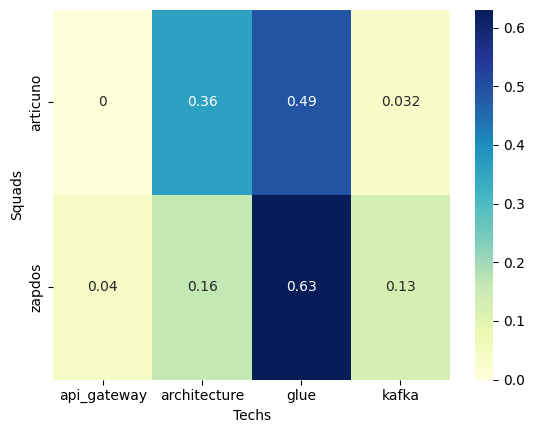

In [4]:
# geracao do primeiro mapa de calor
squads_hm = pd.pivot_table(squads_techs_tech_qs_answered, values='weight', index='squad', columns='tech', fill_value=0)
squads_hm.rename_axis(index='Squads', columns='Techs', inplace=True)
sns.heatmap(squads_hm, annot=True, cmap="YlGnBu")

In [5]:
squads_techs_features_answered = pd.read_csv('squads_techs_features/squads_techs_features.csv')

squads_techs_features_answered = squads_techs_tech_qs_answered.merge(squads_techs_features_answered, on=["tech", "squad"])
squads_techs_features_answered["total_weight"] = squads_techs_features_answered.apply(lambda row: row["weight_x"] * row["weight_y"], axis=1)

squads_techs_features_answered = squads_techs_features_answered.drop(
    columns=[col for col in squads_techs_features_answered.columns if col not in ['tech', 'squad', 'feature', 'total_weight']])

squads_techs_features_answered = squads_techs_features_answered.groupby(['squad', 'feature'])['total_weight'].mean().reset_index()
squads_techs_features_answered.rename(columns={'total_weight': 'mean_total_weight'}, inplace=True)

Text(0.5, 1.0, 'Heatmap')

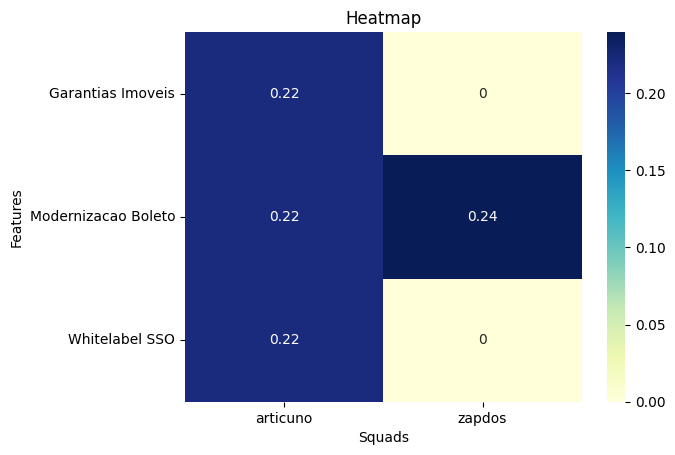

In [6]:
# geracao do mapa de calor do impacto do AS nas features baseado nas tecnologias
features_hm = pd.pivot_table(data=squads_techs_features_answered, values='mean_total_weight', index='feature', columns='squad', fill_value=0)
features_hm.rename_axis(index='Features', columns='Squads', inplace=True)
sns.heatmap(features_hm, annot=True, yticklabels=True, cmap="YlGnBu").set_title("Heatmap")

In [7]:
squads_krs_features_answered = pd.read_csv('squads_krs_features/squads_krs_features.csv')

squads_krs_features_answered = squads_krs_features_answered.merge(squads_techs_features_answered, on=["squad", "feature"])

squads_krs_features_answered['total_weight'] = squads_krs_features_answered['weight'] * squads_krs_features_answered['mean_total_weight'] 
squads_krs_features_answered['mean_total_weight'] = squads_krs_features_answered.groupby(['kr', 'feature'])['total_weight'].transform('mean')
squads_krs_features_answered['squad-feature'] = squads_krs_features_answered['squad'] + '-' + squads_krs_features_answered['feature'] 

Text(0.5, 1.0, 'Heatmap')

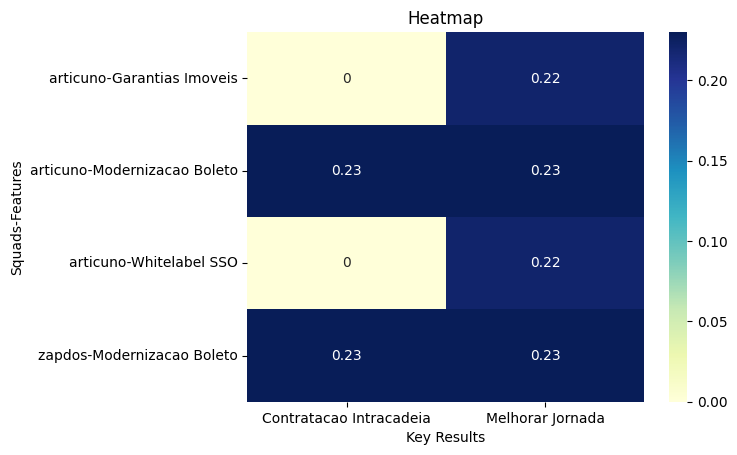

In [8]:
# geracao do mapa de calor do impacto do AS nas krs baseadas nas features que ele impacta
krs_hm = pd.pivot_table(data=squads_krs_features_answered, values='mean_total_weight', index='squad-feature', columns='kr', fill_value=0)
krs_hm.rename_axis(index='Squads-Features', columns='Key Results', inplace=True)
sns.heatmap(krs_hm, annot=True, yticklabels=True, cmap="YlGnBu").set_title("Heatmap")